<a href="https://colab.research.google.com/github/nicepear/Algorithms_LinkedList_Double_Dummy/blob/main/GPT_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title モジュールのインストール
!pip install -qq datasets
!pip install -qq mecab-python3
!pip install -qq unidic-lite
!git clone https://github.com/Michi-123/whiteGPT.git

fatal: destination path 'whiteGPT' already exists and is not an empty directory.


In [ ]:
#@title ライブラリーのインポート
import math
import torch
import torch.nn as nn
import torch.optim as optim # 最適化モジュール
from matplotlib import pyplot as plt # グラフの描画
import MeCab # 形態素解析

In [ ]:
#@title Google Driveのマウント
# from google.colab import drive
# drive.mount('/content/drive')

GPUの使用を判定

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
#@title MeCabの利用 (日本語を形態素解析するプログラム)
tagger = MeCab.Tagger("-Owakati")

In [ ]:
# @title Exercise
tagger.parse('私は昨日公園に行きました。')

'私 は 昨日 公園 に 行き まし た 。 \n'

In [ ]:
# @title 青空文庫データセットの利用
from datasets import load_dataset
ds = load_dataset('globis-university/aozorabunko-clean')

# レクチャー動画の解説通り
ds = ds.filter(lambda row: row['meta']['文字遣い種別'] == '新字新仮名')  # 新字新仮名に限定

In [ ]:
authors = ['夏目'] #@param
# authors = ['夏目'] #@param
titles =['文鳥', '正岡子規']#@param
# titles = [ 'こころ', '三四郎' ,'それから', '坊っちゃん']#@param
# titles = ['文鳥', '正岡子規', '夢十夜']#@param
corpus = ''
for book in ds['train']:
    title = book['meta']['作品名']
    author = book['meta']['姓']
    # if author in authors:
    if title in titles and author in authors:
        print(author, title)
        text = book['text'] # 本文
        text = ''.join(text.split()) # Clean up
        text = tagger.parse(text) # 形態素解析
        corpus += text

print(corpus[:100])

夏目 文鳥
夏目 正岡子規
十 月 早稲田 に 移る 。 伽藍 の よう な 書斎 に ただ 一人 、 片づけ た 顔 を 頬杖 で 支え て いる と 、 三重吉 が 来 て 、 鳥 を 御 飼い なさい と 云う 。 飼っ 


# Hyper parameter

In [ ]:
# @markdown Model parameters

# 512 token GPT1
# 10
context_size = 10 # @param {type: "integer"}

# 768 GPT1 (512+256)
# 192
d_model = 64 #@param {type: "integer"}

# 12 GPT1
# 3
n_head = 2 #@param {type: "integer"}

# 12 layer in  GPT1
# 6
n_block = 3 #@param {type: "integer"}

# @markdown Train parameters
# 64 GPT1
# 64
batch_size = 64  #@param {type: "integer"}

# 2.5e-4
# 0.00025
leraning_rate = 0.00025  #@param {type: "number"}

# 100 GPT1
epoch_num = 150 #@param {type: "integer"}

# pre-trained.pkl
pre_trained_model_path = 'pre-trained.pkl' #@param {type: "string"}

In [ ]:
# ハイパーパラメータの検証
if d_model % n_head != 0:
    print("埋め込みベクトルの次元はヘッドの数で割り切れる必要があります")
    raise ValueError("d_model must be divisible by n_head")

# インスタンス化

In [ ]:
from whiteGPT import GPT, create_attention_mask # 完成コードの利用
from whiteGPT import DataLoader, Evaluate
from whiteGPT import JpTextDataset as Dataset

In [ ]:
# Dataset と DataLoader
dataset = Dataset(corpus, context_size)
train_dataloader = DataLoader(dataset, batch_size, shuffle=True)
test_dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [ ]:
# マスク関数
mask = create_attention_mask(context_size).to(device)

In [ ]:
# 評価モジュールの利用
evaluate = Evaluate(dataset, context_size)

In [ ]:
# 語彙数の取得
vocab_size = len(dataset.vocab)
vocab_size

1596

In [ ]:
# GPTモデルの作成とデバイス対応
model = GPT(vocab_size, context_size, d_model, n_head, n_block)
model.to(device)

GPT(
  (token_embedding): Embedding(1596, 64)
  (positional_encoding): PositionalEncoding()
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer_block): ModuleList(
    (0-2): 3 x TransformerBlock(
      (norm_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention(
        (fc_q): Linear(in_features=64, out_features=64, bias=True)
        (fc_k): Linear(in_features=64, out_features=64, bias=True)
        (fc_v): Linear(in_features=64, out_features=64, bias=True)
        (attention): ScaledDotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (fc): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (fc1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (fc2): Linear(in_features=256, out_features=

In [ ]:
# クロスエントロピー誤差
criterion = nn.CrossEntropyLoss()
# 最適化モジュールの利用
optimizer = optim.Adam(model.parameters(), lr=leraning_rate)

In [ ]:
is_load_model = False # @param{type:"boolean"}
if is_load_model:
    model.load_state_dict(torch.load(pre_trained_model_path, map_location=device))
    print('ok')

# 学習

In [ ]:
#@title 初期化
start_epoch = 0
history = {"train_loss": []}
attn_list = [] # 潜在空間の可視化

epoch:1  index:148 loss:6.653469
source から 右 の 手 で 籠 の 戸 を 明け 
target ながら
output て

epoch:2  index:148 loss:5.482938
source 。 三重吉 は どこ で 買っ た か 、 七子 
target の
output て

epoch:3  index:148 loss:5.462714
source 。 其 時 は 大 に 御 馳走 を し 
target た
output 。

epoch:4  index:148 loss:5.458941
source 。 籠 の 戸 は はたり と 自然 に 落ち 
target た
output 。

epoch:5  index:148 loss:5.457164
source 二 つ 話そう か 。 正岡 と いう 男 は 
target 一向
output 。

epoch:6  index:148 loss:5.456086
source に 入れ た 。 途端 に 文鳥 は 千代 千代 
target と
output 。



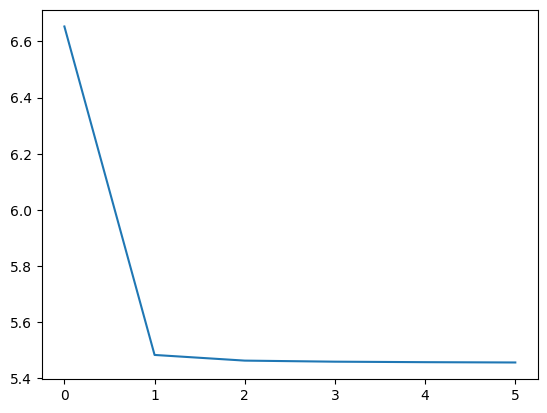

epoch:7  index:148 loss:5.455759
source 。 文鳥 は もう 留り 木 の 上 を 面白 
target そう
output 。

epoch:8  index:148 loss:5.454978
source を 扱う の だ なあ 。 又 正岡 は それ 
target より
output 。

epoch:9  index:148 loss:5.454467
source やろう と 考え て いる うち に 、 とうとう 八 
target 時
output 。

epoch:10  index:148 loss:5.454298
source を し て 見せ たら 、 三重吉 は 頬 ぺた 
target へ
output 。

epoch:11  index:148 loss:5.454735
source た 。 餌 壺 に は 粟 の 殻 ばかり 
target 溜っ
output 。



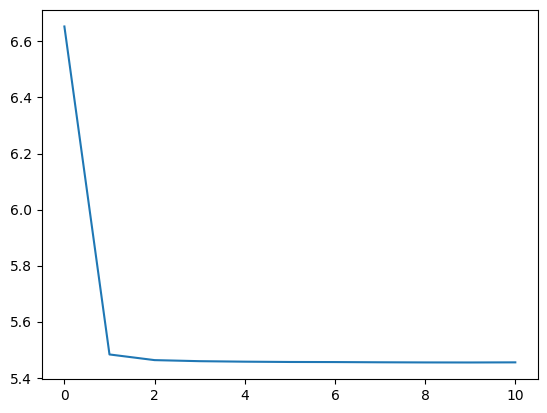

epoch:12  index:148 loss:5.453128
source を 御 飼い なさい と 云う 。 飼っ て も 
target いい
output 。

epoch:13  index:148 loss:5.453157
source 置い た 、 それ を 見せ た 事 が ある 
target 。
output 。

epoch:14  index:148 loss:5.450628
source ぬ ながら 、 書斎 で ペン を 動かし て い 
target た
output 。

epoch:15  index:148 loss:5.435225
source を 圧し つけ て い た 。 胸 の 所 
target が
output て

epoch:16  index:148 loss:5.399337
source 這入っ た 。 縁側 で さらさら 、 さらさら 云う 。 
target 女
output の



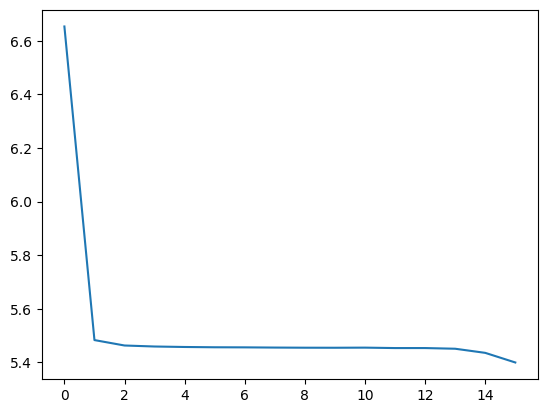

epoch:17  index:148 loss:5.337258
source を 見上げ た 。 それ から 曲げ た 首 を 
target 真直
output に

epoch:18  index:148 loss:5.261217
source から 全体 どこ で 買う の か と 聞い て 
target 見る
output 。

epoch:19  index:148 loss:5.183135
source 豊隆 を 従え て いる 。 豊隆 は いい 迷惑 
target で
output に

epoch:20  index:148 loss:5.107042
source ん 隠し が 邪魔 に なっ て いか ぬ から 
target 、
output 文鳥

epoch:21  index:148 loss:5.032006
source 何 と なく 気の毒 に なっ た 。 三重吉 は 
target 悪い
output は



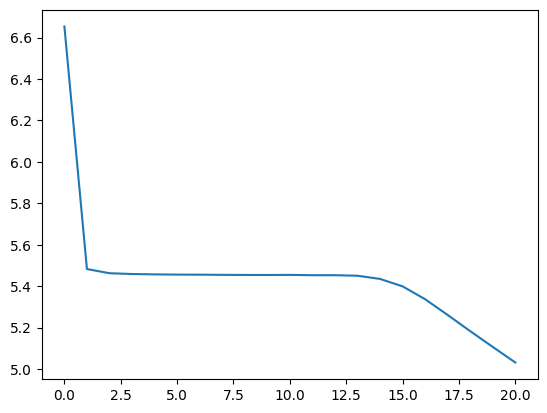

epoch:22  index:148 loss:4.949877
source 一 袋 出し た 。 これ を 毎朝 食わ せ 
target なくっ
output て

epoch:23  index:148 loss:4.874096
source 自分 は 三重吉 が 五 円 札 を たしか に 
target この
output を

epoch:24  index:148 loss:4.799968
source 。 おおかた 眠たい の だろう と 思っ て 、 そっと 
target 書斎
output は

epoch:25  index:148 loss:4.706830
source 。 そう し て また 留り 木 に 乗っ た 
target 。
output 。

epoch:26  index:148 loss:4.625641
source 断念 し て しまっ た 。 今 の 世 に 
target こんな
output 、



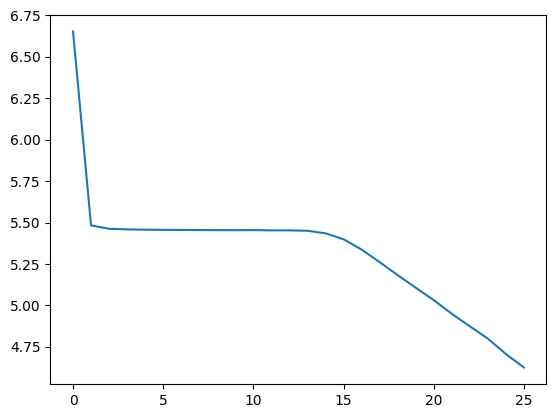

epoch:27  index:148 loss:4.531790
source 買う の か と 聞い て 見る と 、 なに 
target どこ
output は

epoch:28  index:148 loss:4.440941
source と 云っ て いる 。 なるほど 奇麗 だ 。 次の間 
target へ
output は

epoch:29  index:148 loss:4.343852
source に 、 この 縁側 へ 鳥籠 を 据え て やっ 
target たら
output た

epoch:30  index:148 loss:4.249013
source と 聞い て みる と 、 その ため に 箱 
target を
output を

epoch:31  index:148 loss:4.160970
source そう し て その 鳥 を そっち へ 持っ て 
target 行け
output 。



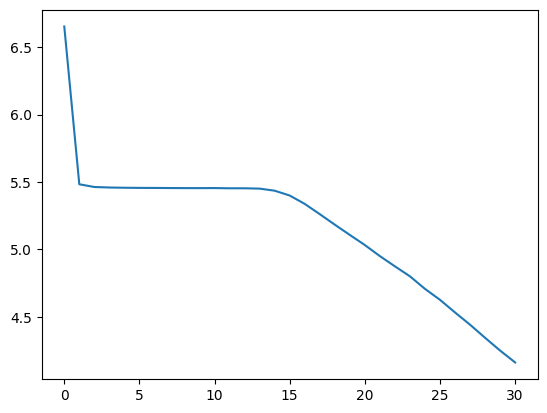

epoch:32  index:148 loss:4.078925
source 所 へ 出る や 否 や 、 いきなり 眼 を 
target しばたたい
output を

epoch:33  index:148 loss:3.991893
source も する そう です と 云う 。 二十 円 は 
target これ
output 僕

epoch:34  index:148 loss:3.918455
source を ふかし て しまっ たら 、 起き て 籠 から 
target 出し
output は

epoch:35  index:148 loss:3.850317
source は 急 に 自分 の 大きな 手 が 厭 に 
target なっ
output 、

epoch:36  index:148 loss:3.778786
source あっ た 。 筆 の 音 に 淋し さ と 
target 云う
output も



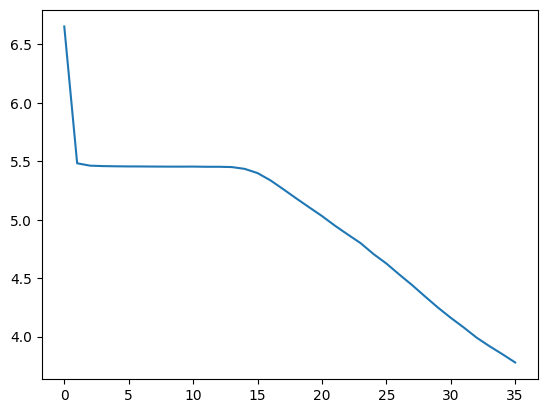

epoch:37  index:148 loss:3.723805
source は 縁談 の きまっ た 二三 日 後 で ある 
target 。
output 。

epoch:38  index:148 loss:3.659368
source 出 て 来 た 。 自分 は 冬 の 日 
target に
output に

epoch:39  index:148 loss:3.599956
source 。 文鳥 が 自分 を 見 た 時 、 自分 
target は
output を

epoch:40  index:148 loss:3.544012
source た 。 大きな 手 を そろそろ 籠 の 中 へ 
target 入れ
output 、

epoch:41  index:148 loss:3.497479
source が 其 を 振り廻す の に 恐れ を 為し て 
target い
output い



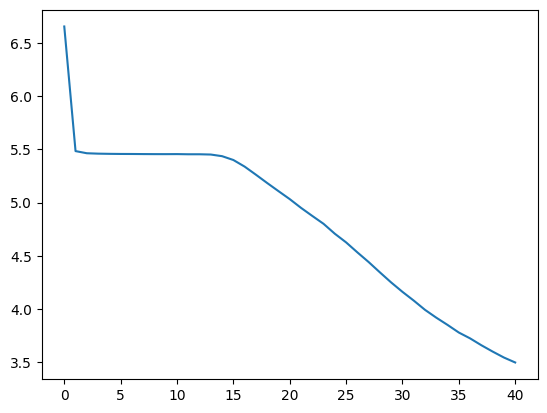

epoch:42  index:148 loss:3.447179
source 大きな 手 を そろそろ 籠 の 中 へ 入れ た 
target 。
output 。

epoch:43  index:148 loss:3.394653
source て 生 呑 込 に し て しまう 。 其 
target 時分
output は

epoch:44  index:148 loss:3.334641
source しかし 殻 も だいぶ 混っ て い た 。 水 
target 入
output は

epoch:45  index:148 loss:3.314352
source の 話 など を し て 帰っ て 行く 。 
target 文鳥
output 僕

epoch:46  index:148 loss:3.282958
source 一応 撮ん で 見る 。 それ で も 筆 と 
target 紙
output 否



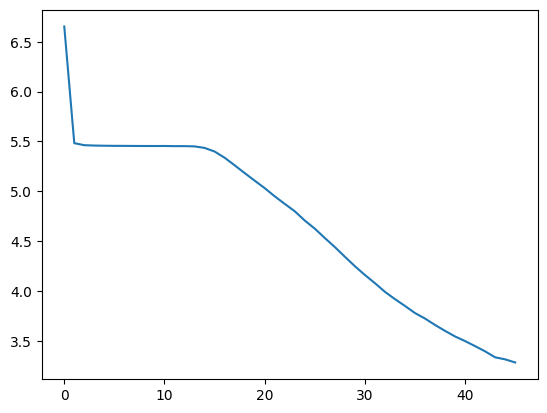

epoch:47  index:148 loss:3.241965
source 仰山 で ある 。 雛段 を あるく 、 内裏 雛 
target の
output を

epoch:48  index:148 loss:3.202346
source 事 も 何 か 書い て あっ た 。 これ 
target は
output は

epoch:49  index:148 loss:3.166341
source を 見 て ことさら に 鳴く 気色 は さらに なかっ 
target た
output 、

epoch:50  index:148 loss:3.144264
source あっ た 。 ところ が 出 て 見る と 粟 
target が
output は

epoch:51  index:148 loss:3.108504
source 。 する と 縁側 で 文鳥 が たちまち 千代 千代 
target と
output を



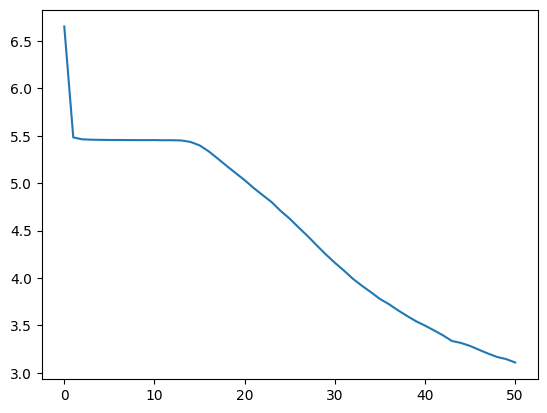

epoch:52  index:148 loss:3.069632
source れる が 、 ただ の 女 の それ と し 
target て
output て

epoch:53  index:148 loss:3.051993
source 出 て 見る と 、 文鳥 は 自分 の 方 
target を
output に

epoch:54  index:148 loss:3.025649
source 出し て 見 たら 、 はたして 出し て あっ た 
target 。
output 。

epoch:55  index:148 loss:3.012065
source です から 、 もう 死ん だ か も 知れ ませ 
target ん
output 聴え

epoch:56  index:148 loss:2.980843
source と 、 文鳥 は 静 に 掌 の 上 に 
target ある
output 見



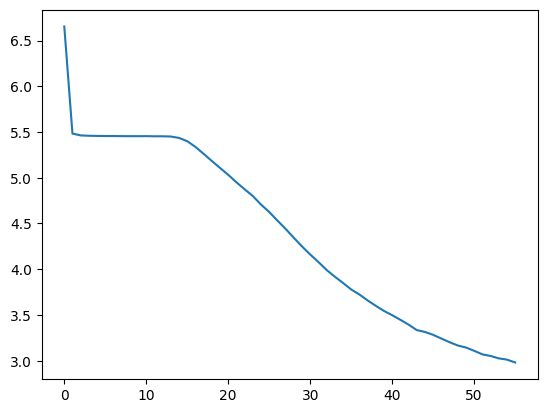

epoch:57  index:148 loss:2.945002
source 大丈夫 な の か ね と 聞き返す と 、 まあ 
target 鳥
output 承知

epoch:58  index:148 loss:2.928869
source 。 夜 に なれ ば この 箱 に 入れ て 
target やる
output いる

epoch:59  index:148 loss:2.903434
source 責任 を 負わ せる の は 当然 の 事 だ 
target から
output た

epoch:60  index:148 loss:2.872923
source て いる 。 彼 は 僕 など より 早熟 で 
target 、
output いる

epoch:61  index:148 loss:2.833907
source の ところ へ 遣っ て 来 た 。 自分 の 
target うち
output とうとう



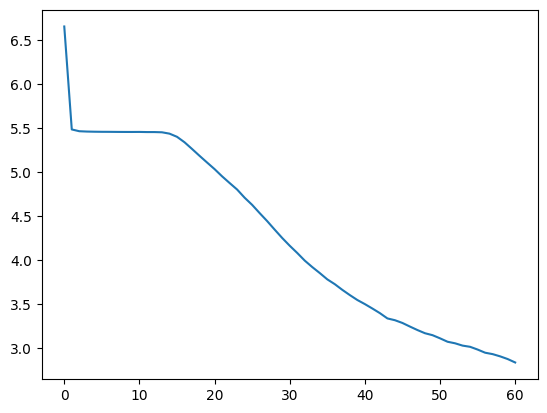

epoch:62  index:148 loss:2.802982
source 落ち た 。 文鳥 は 留り 木 の 上 に 
target 戻っ
output 戻っ

epoch:63  index:148 loss:2.764771
source ぴたり と やむ 、 また やめ ね ば なら ぬ 
target 、
output 。

epoch:64  index:148 loss:2.726404
source 度 左右 に 振っ た 。 奇麗 に 平 し 
target て
output て

epoch:65  index:148 loss:2.679781
source 。 自分 は 急 に 自分 の 大きな 手 が 
target 厭
output 厭

epoch:66  index:148 loss:2.642497
source と 判ら ない が 、 まあ 安い なあ と 云っ 
target て
output た



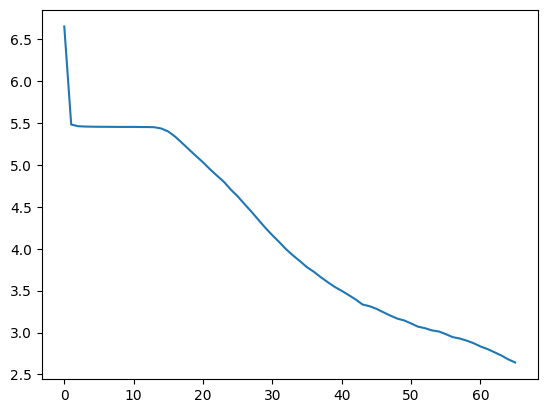

epoch:67  index:148 loss:2.604044
source 嫁 に 行っ た 。 自分 が 紫 の 帯 
target 上
output 怠け

epoch:68  index:148 loss:2.553079
source へ 餌 を 入れ て 、 もう 一 つ に 
target は
output 見

epoch:69  index:148 loss:2.506381
source と 怒鳴りつけ たら 、 驚い て 台所 の 方 へ 
target 持っ
output いう

epoch:70  index:148 loss:2.466048
source せる たび に 絹糸 が 急 に 寄っ て 一 
target 本
output それ

epoch:71  index:148 loss:2.420372
source 箱 に なっ た の は この 初冬 の 晩 
target で
output に



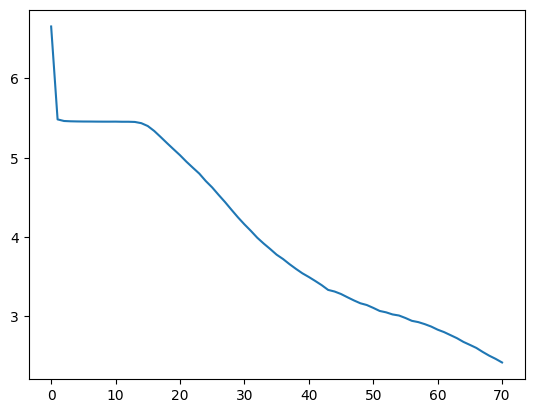

epoch:72  index:148 loss:2.377131
source は そう で は 無かっ た 。 身代 を 皆 
target 食いつぶし
output 食いつぶし

epoch:73  index:148 loss:2.340220
source た 。 かよう に し て 金 は たしか に 
target 三重吉
output 食っ

epoch:74  index:148 loss:2.304343
source 自分 は やむ を え ず 餌 壺 を 持っ 
target た
output て

epoch:75  index:148 loss:2.252468
source 。 其 時 は 大 に 御 馳走 を し 
target た
output て

epoch:76  index:148 loss:2.204966
source 炭 ばかり 継い で いる 。 文鳥 は ついに 忘れ 
target た
output て



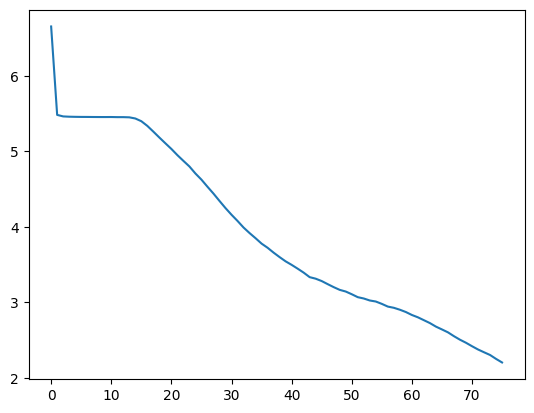

epoch:77  index:148 loss:2.171568
source 思っ た 。 文鳥 に つい て 万事 を 説明 
target し
output し

epoch:78  index:148 loss:2.145418
source 間 に は 折々 千代 千代 と 云う 声 も 
target 聞え
output 聞え

epoch:79  index:148 loss:2.112230
source に 黒味 が 取れ て だんだん 朱 の 色 が 
target 出
output 出

epoch:80  index:148 loss:2.065955
source 。 三重吉 は 用意 周到 な 男 で 、 昨夕 
target 叮嚀
output 叮嚀

epoch:81  index:148 loss:2.039916
source 決心 し た 。 翌日 文鳥 は 鳴か なかっ た 
target 。
output 。



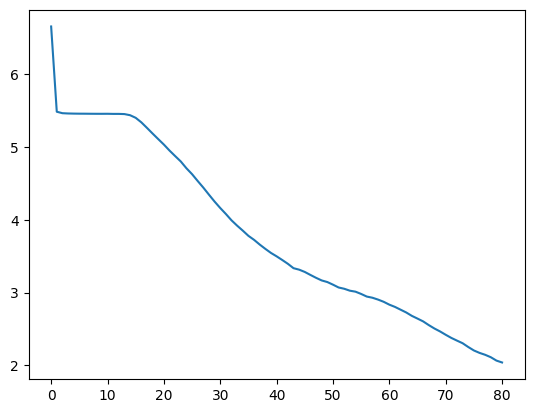

epoch:82  index:148 loss:2.004885
source た よう に 縁側 へ 出 て 見る と 、 
target いつ
output 文鳥

epoch:83  index:148 loss:1.988939
source いや に 哲学 など を 振り廻す もの だ から 、 
target 僕
output もし

epoch:84  index:148 loss:1.956906
source 。 する と 三 分 ばかり し て 、 今度 
target は
output へ

epoch:85  index:148 loss:1.938100
source 矢張り 気位 の 高い 仲間 で あっ た 。 ところ 
target が
output の

epoch:86  index:148 loss:1.903025
source の まま 長らく 留り 木 の 上 を 動か なかっ 
target た
output い



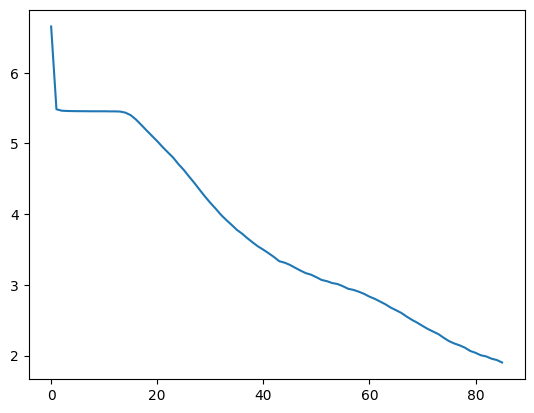

epoch:87  index:148 loss:1.877819
source 。 いっしょ に 晩飯 を 食う 。 その 上 明日 
target の
output を

epoch:88  index:148 loss:1.849090
source へ 出 た 。 小指 を 掛け て も すぐ 
target 引っ繰り返り
output 引っ繰り返り

epoch:89  index:148 loss:1.834493
source 鳥 を 見つめ て い た 。 それ から 、 
target そっと
output 煙

epoch:90  index:148 loss:1.826822
source そう し て 文鳥 が 鳴か ない 。 その うち 
target 霜
output の

epoch:91  index:148 loss:1.806669
source と で も 思っ た の で あろう 。 それ 
target から
output の



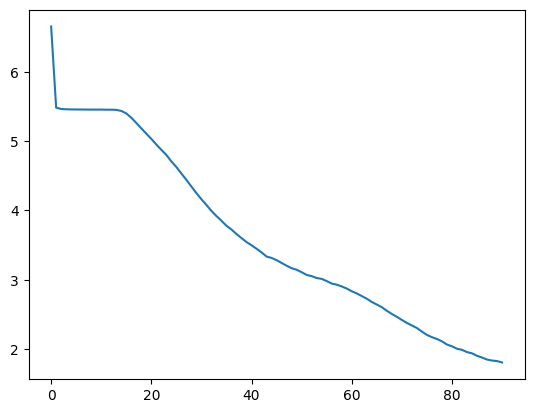

epoch:92  index:148 loss:1.765454
source た 。 その 一 本 を 軽く 踏まえ た 足 
target を
output を

epoch:93  index:148 loss:1.762544
source て いる 。 それ から 全体 どこ で 買う の 
target か
output 書斎

epoch:94  index:148 loss:1.730733
source し た 時 、 先生 も 大に 寄席 通 を 
target 以
output 以

epoch:95  index:148 loss:1.723168
source に 鳥籠 の 桟 に かじりつい て い た 。 
target 自分
output その

epoch:96  index:148 loss:1.706436
source ない が 、 先生 得意 に なっ て やる 。 
target 何
output 豊隆



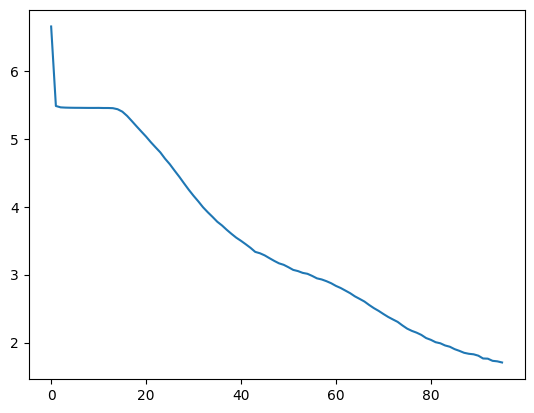

epoch:97  index:148 loss:1.695768
source 三重吉 が 大きな 箱 を 兄き 分 に 抱え て 
target いる
output いる

epoch:98  index:148 loss:1.677383
source 洗っ て 飯 を 食う まで は 縁側 を 覗か 
target なかっ
output の

epoch:99  index:148 loss:1.668826
source で 極めて 居る 。 御 承知 の 通り 僕 は 
target 上野
output 上野

epoch:100  index:148 loss:1.639956
source か はなはだ 疑わしい 。 おそらく 古代 の 聖徒 の 仕事 
target だろう
output だろう

epoch:101  index:148 loss:1.633216
source 講釈 は だいぶ 込み入っ た もの で あっ た が 
target 、
output あっ



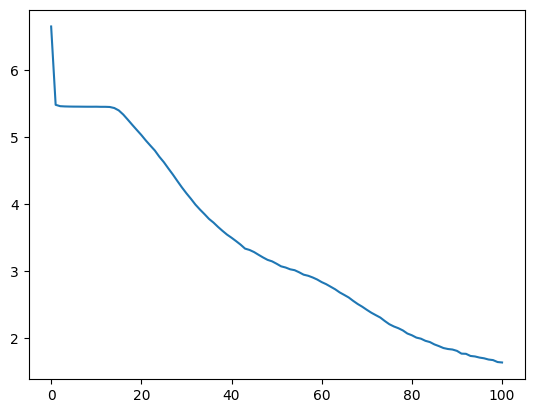

epoch:102  index:148 loss:1.617636
source だ 。 現に 三重吉 の 飼っ て い た 文鳥 
target は
output は

epoch:103  index:148 loss:1.595962
source へ 出 て 見る と 、 鳥籠 が 箱 の 
target 上
output 中

epoch:104  index:148 loss:1.579180
source を 皆 食いつぶし て い た の だ 。 其 
target 後
output 後

epoch:105  index:148 loss:1.567764
source 日 が 善く 当る 。 そう し て 文鳥 が 
target 鳴か
output 鳴か

epoch:106  index:148 loss:1.552879
source で あっ た 。 二三 度 試み た 後 、 
target 自分
output 、



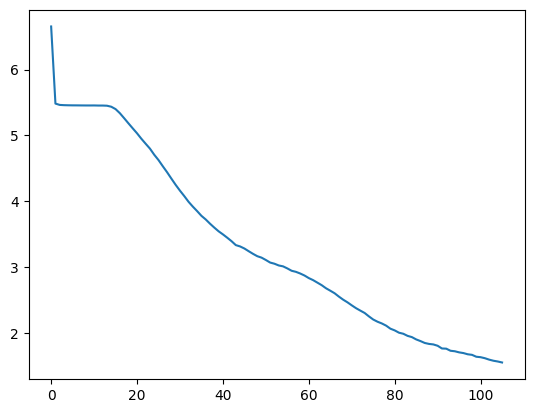

epoch:107  index:148 loss:1.539739
source 幼稚 な もの で あっ た 。 妙 に 気位 
target の
output に

epoch:108  index:148 loss:1.527668
source に 比べ て 安い の は 無論 で ある 。 
target この
output 自分

epoch:109  index:148 loss:1.515608
source 見つめ て い た 。 それ から 、 そっと 座 
target 布団
output 布団

epoch:110  index:148 loss:1.500918
source 。 その うち 霜 が 降り 出し た 。 自分 
target は
output は

epoch:111  index:148 loss:1.477098
source に 居 た もの だ から 、 時刻 に なる 
target と
output と



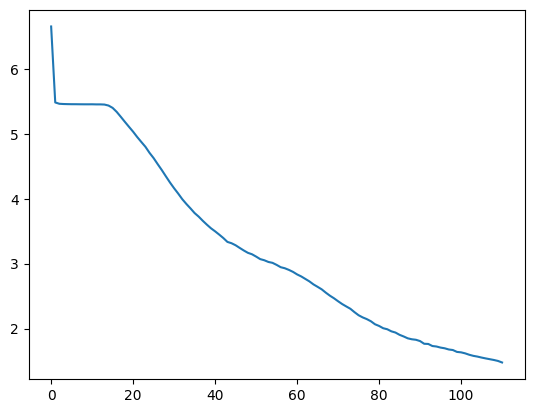

epoch:112  index:148 loss:1.470489
source ため に は なかなか 強硬 で ある 。 それ を 
target はい
output 色

epoch:113  index:148 loss:1.451647
source て やっ た 。 如 露 の 水 が 尽きる 
target 頃
output 頃

epoch:114  index:148 loss:1.435930
source て 、 籠 の 外 に いる 自分 を 見上げ 
target た
output た

epoch:115  index:148 loss:1.422330
source た 。 明る 朝 目 が 覚める と 、 外 
target は
output に

epoch:116  index:148 loss:1.404677
source 抛り出し て おい て 、 急い で 餌 と 水 
target を
output を



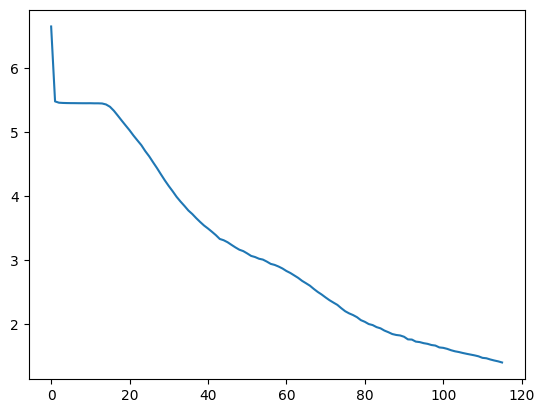

epoch:117  index:148 loss:1.382201
source 。 文鳥 の 足 は 向う の 留り 木 の 
target 真中
output 。

epoch:118  index:148 loss:1.378152
source で も 僕 が 松山 に 居 た 時分 、 
target 子規
output 子規

epoch:119  index:148 loss:1.367055
source が 、 まず やっ て みよう と まで は 決心 
target し
output し

epoch:120  index:148 loss:1.343190
source で 、 大将 奥 座敷 に 陣取っ て 威張っ て 
target いる
output い

epoch:121  index:148 loss:1.335916
source さえ 難儀 だ 。 それ で も 煙草 は 一 
target 本
output 本



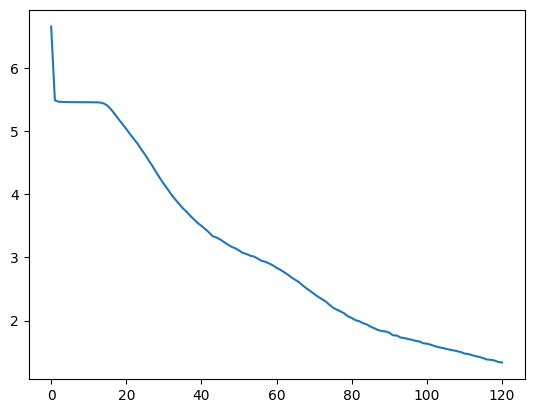

epoch:122  index:148 loss:1.318147
source 月 早稲田 に 移る 。 伽藍 の よう な 書斎 
target に
output で

epoch:123  index:148 loss:1.302838
source を 卸し て 、 その 前 へ かしこまっ て 、 
target 籠
output こちら

epoch:124  index:148 loss:1.293480
source だ が 僕 は 正岡 ほど 熟さ なかっ た 。 
target 或
output 或

epoch:125  index:148 loss:1.277175
source 台 を 眺め た 。 空 に なっ た 餌 
target 壺
output も

epoch:126  index:148 loss:1.259068
source の ごとく ペン の 音 を 立て て 侘びしい 事 
target を
output を



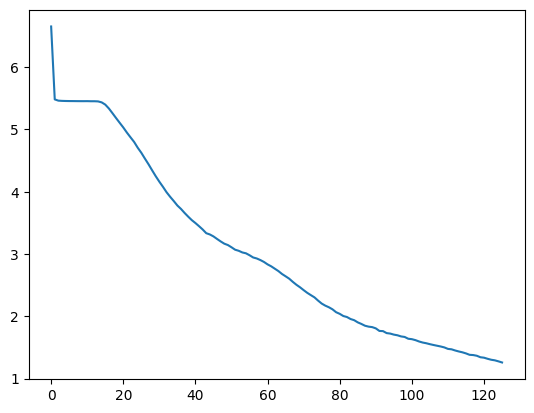

epoch:127  index:148 loss:1.257673
source 水 入 の 縁 に ひょい と 飛び上る 。 しばらく 
target し
output し

epoch:128  index:148 loss:1.239120
source 善く 当る 。 そう し て 文鳥 が 鳴か ない 
target 。
output 。

epoch:129  index:148 loss:1.214771
source 入 も 餌 壺 も 引繰返っ て いる 。 粟 
target は
output は

epoch:130  index:148 loss:1.206187
source に いう もの だ から 、 其 時分 何 も 
target 分ら
output 分ら

epoch:131  index:148 loss:1.202340
source を 透し て 五 尺 の 縁側 に は 日 
target が
output が



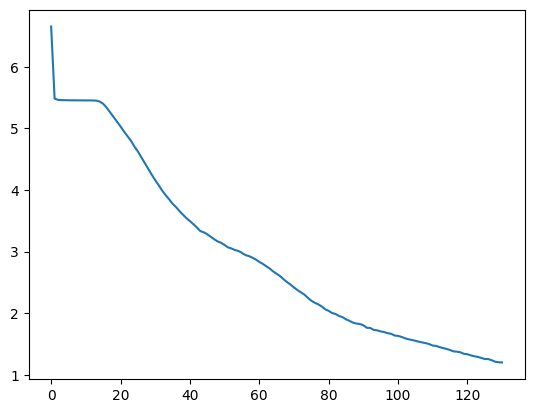

epoch:132  index:148 loss:1.179710
source そう し て 時々 は 首 を 伸し て 籠 
target の
output の

epoch:133  index:148 loss:1.175866
source 、 まず やっ て みよう と まで は 決心 し 
target た
output た

epoch:134  index:148 loss:1.163372
source 、 ここ いら が 好い でしょう と 云っ て いる 
target 。
output 。

epoch:135  index:148 loss:1.137667
source この 女 が 机 に 凭れ て 何 か 考え 
target て
output た

epoch:136  index:148 loss:1.114095
source は 伽藍 の よう な 書斎 の 真中 に 床 
target を
output を



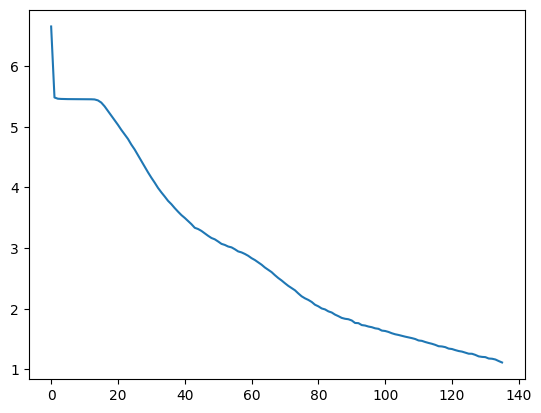

epoch:137  index:148 loss:1.126457
source は 無暗 に 手紙 を よこし た 男 で 、 
target それ
output 僕

epoch:138  index:148 loss:1.118359
source ある 。 まあ 御覧 なさい と 云う 。 豊隆 その 
target 洋灯
output 洋灯

epoch:139  index:148 loss:1.100856
source 二十 円 は これ で 二 返 目 で ある 
target 。
output 。

epoch:140  index:148 loss:1.097364
source 寄っ て 一 本 に なる 。 と 思う と 
target また
output と

epoch:141  index:148 loss:1.071433
source 上 まだ 金 を 貸せ と いう 。 何 で 
target も
output も



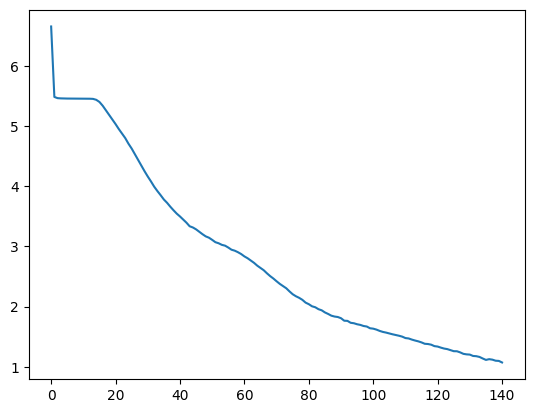

epoch:142  index:148 loss:1.072564
source する と いう 事 が 書い て あっ て 、 
target 外
output ペン

epoch:143  index:148 loss:1.045390
source ない ほど 白い 。 何 だ か 寒 そう だ 
target 。
output 。

epoch:144  index:148 loss:1.044166
source に 、 当人 一人 で 極めて 居る 。 御 承知 
target の
output の

epoch:145  index:148 loss:1.033842
source 、 行っ て も え え けれど 又 鮭 で 
target 飯
output 飯

epoch:146  index:148 loss:1.027172
source 文鳥 は また 眼 を 開い た 。 同時 に 
target 真白
output 真白



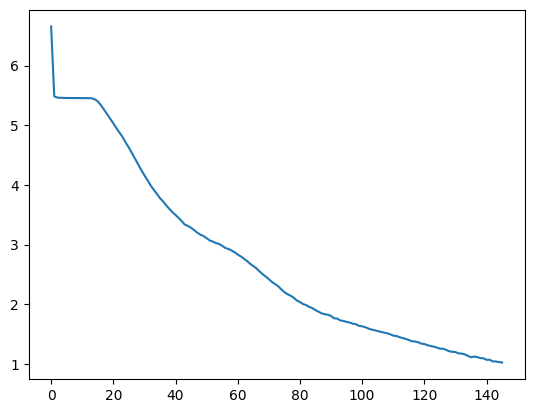

epoch:147  index:148 loss:0.994553
source 顔 を わざと ほてら し て い た の が 
target 、
output 、

epoch:148  index:148 loss:1.005074
source やっぱり 八 時 過ぎ で あっ た 。 箱 の 
target 中
output 中

epoch:149  index:148 loss:0.983402
source の 傍 へ しゃがん だ 。 文鳥 は 膨らん だ 
target 首
output 首

epoch:150  index:148 loss:0.971661
source の 至り だ 」 と 云う 文句 で あっ た 
target 。
output 。



In [ ]:
#@title Train

# Epoch数まで繰り返し
for epoch in range(start_epoch, epoch_num):

    # 損失の累計をリセット
    running_loss = 0.0

    # 学習モードに変更
    model.train()

    # 学習データセット全体をバッチ単位で処理
    for i, batch in enumerate(train_dataloader):

        # 入力元データと教師データ
        source = batch['source'].to(device)
        target = batch['target'].to(device).view(-1)

        # 勾配のリセット
        optimizer.zero_grad()

        # 推論
        outputs, w = model(source, mask)

        # 損失計算
        loss = criterion(outputs, target)

        # 誤差逆伝播
        loss.backward()

        # 学習パラメータの更新
        optimizer.step()

        # 損失の累積
        running_loss += loss.item()

        # print( i , len(train_dataloader))

    # 損失の履歴を作成
    train_loss = running_loss / len(train_dataloader)
    history["train_loss"].append(train_loss)

    # 開始epochの更新
    start_epoch = epoch

    # 損失の確認
    if epoch % 1 == 0:
        print(f"epoch:{epoch+1}  index:{i+1} loss:{train_loss:.6f}")
        evaluate.predict(source, target, outputs)

    # グラフの描画
    if epoch % 5 == 0 and epoch != 0:
        plt.plot(history['train_loss'])
        plt.show()

    # モデルの保存
    if epoch % 10 == 0 and epoch != 0:
        torch.save(model.state_dict(), pre_trained_model_path )


    ## 可視化の処理（Epochごとに重みを格納します）
    # 評価モードに変更
    model.eval()
    # 推論
    _, w = model(source)
    # Attentionの潜在空間の履歴を作成
    attn_list.append(w[0].detach())

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

1275260


In [ ]:


print(model.parameters)

<bound method Module.parameters of GPT(
  (token_embedding): Embedding(1596, 64)
  (positional_encoding): PositionalEncoding()
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer_block): ModuleList(
    (0-2): 3 x TransformerBlock(
      (norm_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention(
        (fc_q): Linear(in_features=64, out_features=64, bias=True)
        (fc_k): Linear(in_features=64, out_features=64, bias=True)
        (fc_v): Linear(in_features=64, out_features=64, bias=True)
        (attention): ScaledDotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (fc): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (fc1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (fc2): Li

In [ ]:
torch.save(model.state_dict(), pre_trained_model_path )

# Test

In [ ]:
# モデルの読み込み
model.load_state_dict(torch.load(pre_trained_model_path, map_location=device))
# 評価モードに設定
_ = model.eval()

https://www.aozora.gr.jp/cards/000148/files/753_42587.html

In [ ]:
sample_corpus = "それから全体どこで買うのかと聞いて見ると" #@param{type:"string"}
parsed_corpus = tagger.parse(sample_corpus)
print(sample_corpus)
evaluate.generate(parsed_corpus, model, mask)

それから全体どこで買うのかと聞いて見ると
て見ると、なにどこの鳥屋から、時首をやると、文鳥は箱を似ている。一上がなかなか無邪気である。昔紫の帯上でいたずらをした女は襟の長い、背のすらりと、よく紫を一度にしている。留り木の上に真珠を削った。よく見るのだろうと、当人はそっと留り木の上だけ方向を換えていた。しきりに好き嫌いを左右に傾けるとしている。豊隆はうんその首をぱちぱち入れてやると、丸くて見た。しかも畳所に粟をやると、丸くてみた。殻はとうとう家の上を卸して行った。けれど、これは僕は千代千代する。そうしていた。留り木の通り水も新しくなって、心持自分のうちへ水を書斎へ籠を据えて見て、二三て文鳥処で二本しかないものだ。僕が其時分の事を持ってやるように、粟を出して行った。文鳥はとうとう餌足をぱちぱちしてしまった。自分は手紙の中に立っていた。それから文鳥は粟鳴か殻を箱の金を出したような心持で其聞いて飯をまあ―出して行った。けれども僕は僕は千代千代しているくらいを握った。文鳥は眼をぱちつかせている。もっと早く起きたかったろうと思ったら気の毒になっていた。一本ので二十円を紙を持って行っていた。翌日文鳥は水鳴かになってしまった。自分はまた僕の前にしゃがんを挟んで行った。それで時は僕の方に人をしていた。それでも文鳥はいっこう千代して行水を使っている。自分は急に易と蒲焼の金をして、漢籍の中から籠を眺めて、縁側の上へ入れて来て鳥籠を――と、まだそうに承知なさい通り好い分中でさらさら文鳥を出して、自分の前へ抛り出した。小女は俯向いて畳を眺めて、黙っている。自分は僕は箱の中に落ちて、じっと鳥籠を見守って、心持手だけの上で中のかをすぐペンの左の顔をして硝子ようになっ